In [1]:
import os 

import numpy as np 
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

plt.style.use(os.path.join(os.path.abspath(''), 'plot_style.mplstyle'))
plots_dir = 'plots/'

from pypower import BaseMatrix
from desilike.samples import Profiles, Chain, plotting
from emulator_fit import get_power_likelihood, get_corr_likelihood, get_footprint

tracer = 'ELG'
region = 'SGC'
completeness = 'complete_'
stat = 'power'
theory_name = 'velocileptors'
rp_cut = 2.5
xinmax = True
solve = True
fc = ''
imock = None
direct = False

In [2]:
data_dir = '/global/cfs/cdirs/desi/users/mpinon/'

emulator_dir = '/global/cfs/cdirs/desi/users/mpinon/emulators/emulators_shapefit_{}'.format(tracer)

In [3]:
likelihood = get_power_likelihood(tracer=tracer, region=region, completeness=completeness, theory_name=theory_name, fc=fc, rp_cut=rp_cut, direct=direct, emulator_fn=os.path.join(emulator_dir, 'power_xinmax0.35_{}.npy'))

footprint


/global/u2/m/mpinon/desi_fiber_collisions/emulator_fit.py:37: RuntimeWarning: invalid value encountered in scalar divide
  alphas = [wsum_data / wsum_randoms / alpha for wsum_data, wsum_randoms in zip(wsums_data, wsums_randoms)]


Renormalizing randoms weights by [nan, 1.0] before concatenation.


/global/cfs/cdirs/desi/users/adematti/perlmutter/cosmodesiconda/20221205-1.0.0/conda/lib/python3.10/site-packages/numpy/lib/polynomial.py:1337: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


In [4]:
factorin = 10
factorout = 5
xlim = (0.01, 0.6)

rp_cuts = [10, 20, 30]

wm = BaseMatrix.load('/global/cfs/cdirs/desi/users/mpinon/windows/wm_mock0_ELG_complete_SGC.npy')
wm_rpcut = BaseMatrix.load('/global/cfs/cdirs/desi/users/mpinon/windows/wm_mock0_ELG_complete_SGC_rp2.5.npy')

def unpack_wm(wmatrix):
    window_matrix = wmatrix.deepcopy()
    window_matrix.slice_x(slicein=slice(0, len(window_matrix.xin[0]) // factorin * factorin, factorin), sliceout=slice(0, len(window_matrix.xout[0]) // factorout * factorout, factorout))
    window_matrix.select_x(xoutlim=(0.01, 0.25))
    window_matrix.select_x(xinlim=xlim)
    return window_matrix, window_matrix.unpacked()

wm, a = unpack_wm(wm)
wm_rpcut, a_rpcut = unpack_wm(wm_rpcut)

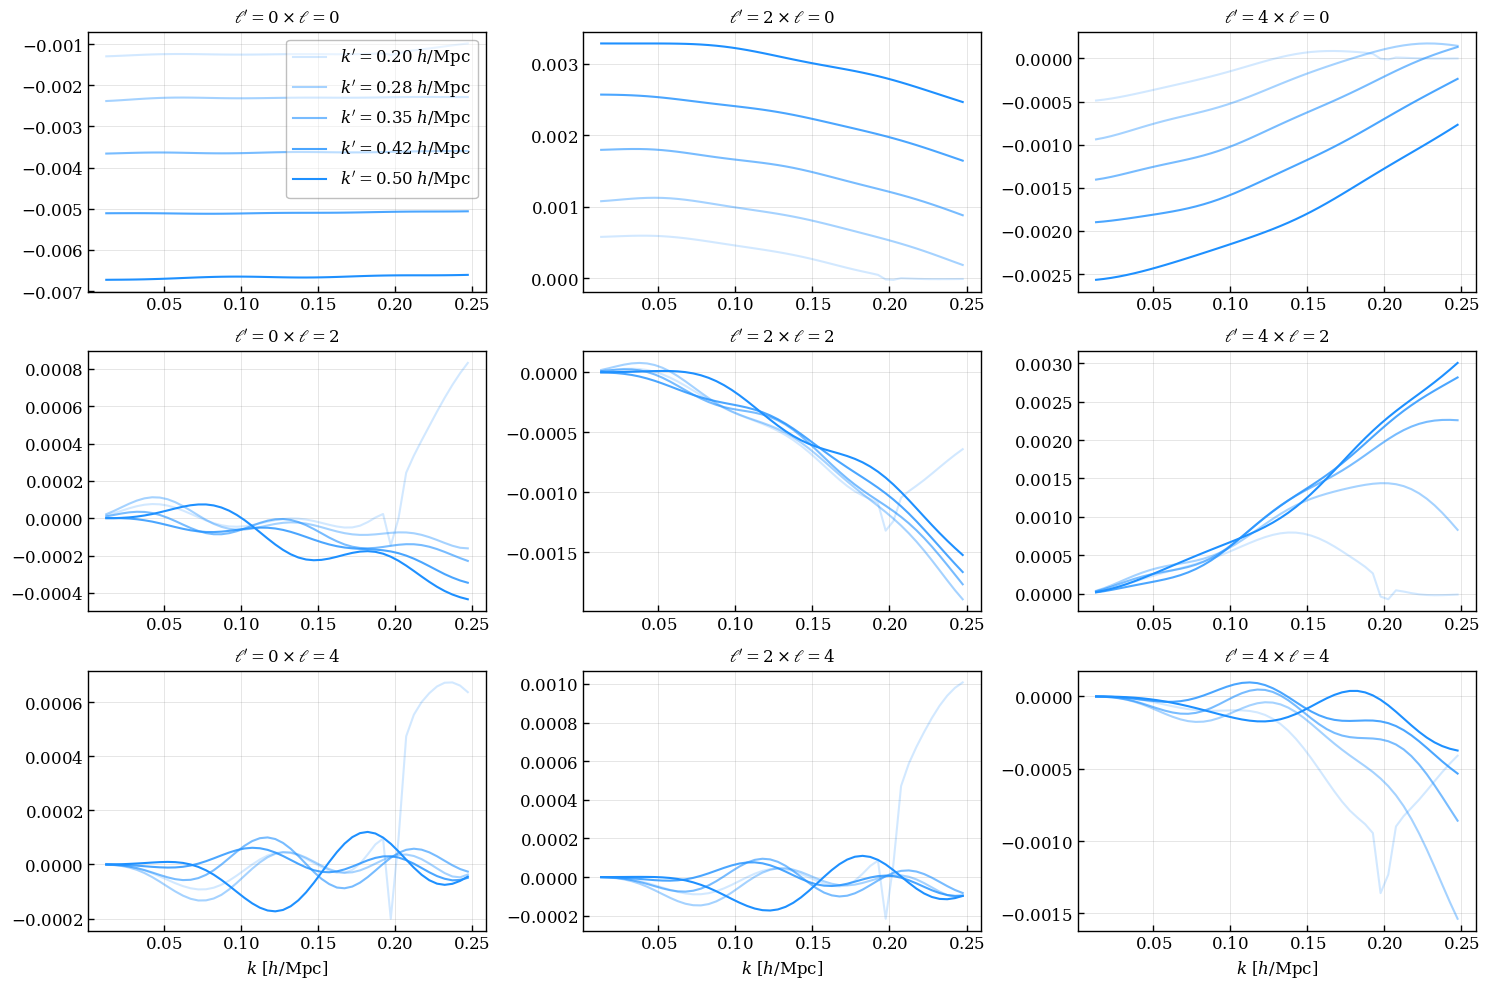

In [5]:
kprime_vals = np.linspace(0.2, 0.5, 5)
indexin_list = [np.abs(wm.xin[0] - kval).argmin() for kval in kprime_vals]

fig, lax = plt.subplots(len(wm.projsout), len(wm.projsin), figsize=(15, 10))
for iin, projin in enumerate(wm.projsin):
    for iout, projout in enumerate(wm.projsout):
        ax = lax[iout][iin]
        # Indices in approximative window matrix
        norm = 1.
        for i, indexin in enumerate(indexin_list):
            ax.plot(wm.xout[iin], (a_rpcut[iin][iout][indexin, :] - a[iin][iout][indexin, :]) / norm, label=r'$k^\prime = {:.2f} \; h/\mathrm{{Mpc}}$'.format(kprime_vals[i]), color='dodgerblue', alpha=(i+1)/len(kprime_vals))
        ax.set_title(r'$\ell^\prime = {:d} \times \ell = {:d}$'.format(projin.ell, projout.ell))
        ax.grid(True)
        if iout == len(wm.projsout) - 1: ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
        if iin == iout == 0: lax[iout][iin].legend()
plt.savefig(os.path.join(plots_dir, 'wmatrix_rpcut_complete_diff_fixedkin.png'), dpi=300)
plt.show()

In [6]:
cov = np.load(os.path.join(data_dir, 'cov_{}_{}{}{}{}.npy'.format(tracer, completeness, region, '_rp{:.1f}'.format(rp_cut) if (rp_cut and not fc) else '', '_directedges_max5000' if rp_cut and direct else '')))
#cov = cov[:36, :36]

In [7]:
wm = BaseMatrix.load('/global/cfs/cdirs/desi/users/mpinon/windows/wm_mock0_ELG_complete_SGC.npy')
wm_rpcut = BaseMatrix.load('/global/cfs/cdirs/desi/users/mpinon/windows/wm_mock0_ELG_complete_SGC_rp2.5.npy')
wmatrix = wm_rpcut.deepcopy()
#wmatrix.select_proj(projsin=[0], projsout=[(0, None)])
#wmatrix.value -= wm.value

In [8]:
wmatrix.shape

(23289, 1569)

In [9]:
klim={0: [0.02, 0.2, 0.005], 2: [0.02, 0.2, 0.005], 4: [0.02, 0.2, 0.005]}
factorout = 5
for iout, projout in enumerate(wmatrix.projsout):
    wmatrix.slice_x(sliceout=slice(0, len(wmatrix.xout[iout]) // factorout * factorout, factorout), projsout=projout)
wmatrix.select_x(xoutlim=klim[0][:2])                

In [10]:
def matrix_lininterp(xin, xout):
    # Matrix for linear interpolation
    toret = np.zeros((len(xout), len(xin)), dtype='f8')
    for iout, xout in enumerate(xout):
        iin = np.searchsorted(xin, xout, side='right') - 1
        if 0 <= iin < len(xin) - 1:
            frac = (xout - xin[iin]) / (xin[iin + 1] - xin[iin])
            toret[iout, iin] = 1. - frac
            toret[iout, iin + 1] = frac
        elif np.isclose(xout, xin[-1]):
            toret[iout, iin] = 1.
    return toret

test = matrix_lininterp(wmatrix.xin[0], wmatrix.xout[0])

In [11]:
#wmatrix.value = test.T

In [12]:
wmatrix.value[wmatrix.value > 0]

array([1.05405507e-10, 5.66252223e-11, 3.86813803e-11, ...,
       1.00543159e-07, 1.96875010e-06, 3.61907669e-06])

In [13]:
np.where(wmatrix.value > 0)

(array([    0,     0,     0, ..., 23288, 23288, 23288]),
 array([  0,   1,   2, ...,  98, 106, 107]))

In [14]:
ells = [0, 2, 4]
nells = len(ells)

idx = 6800

ta = np.zeros((wmatrix.shape[0], nells))
for i in range(nells):
    #ta[wmatrix.shape[0] // nells * (i+1) - 1] = 1
    ta[i * (wmatrix.shape[0]  // nells) + idx][i] = 1

In [16]:
wmatrix.xin[0][idx]

0.3575069158373422

In [429]:
wmatrix.shape[0]  // nells

7763

In [430]:
np.where(ta > 0)

(array([ 6800, 14563, 22326]), array([0, 1, 2]))

In [431]:
wmatrix.value.T.dot(ta).shape

(108, 3)

In [432]:
def aprime(a, w, ta):
    w = w.value.T
    t = np.asarray(ta)
    print((w.dot(t)).T.shape)
    tmp = (w.dot(t)).T.dot(a).dot(w.dot(t))
    tmpinv = np.linalg.inv(tmp)
    tmp2 = t.dot(tmpinv).dot(t.T)
    anew = (a @ w.dot(tmp2).dot(w.T) @ a)
    return a - anew

In [433]:
invcov = np.linalg.inv(cov)

anew = aprime(invcov, wmatrix, ta)

(3, 108)


In [437]:
#plt.plot(wmatrix.xout[0], wmatrix.dot(ta[:, 0]))

In [438]:
anew.max()

0.001996787807033286

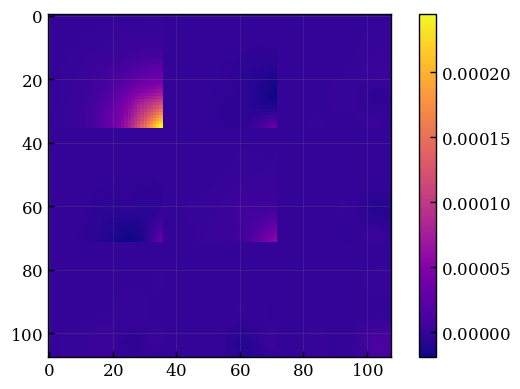

In [439]:
#norm = Normalize(vmin=-0.0008, vmax=0.003)

plt.imshow(invcov - anew)
plt.colorbar()
plt.show()

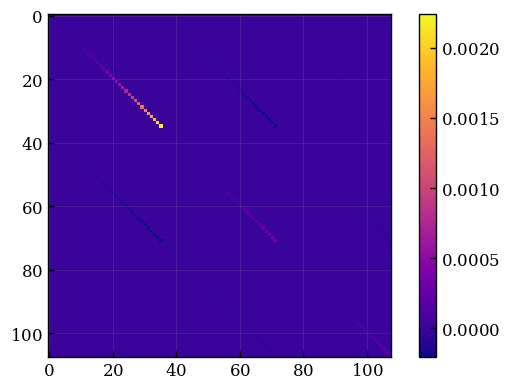

In [440]:
plt.imshow(invcov)
plt.colorbar()
plt.show()

In [445]:
import scipy.linalg as sla

evalues, evectors = sla.eig(anew)

In [446]:
evalues, evectors

(array([ 2.20833747e-03+0.j,  2.03281746e-03+0.j,  1.87321134e-03+0.j,
         1.72433169e-03+0.j,  1.58223309e-03+0.j,  1.44399548e-03+0.j,
         1.30803968e-03+0.j,  1.17457944e-03+0.j,  1.04636570e-03+0.j,
         9.26045077e-04+0.j,  8.16077315e-04+0.j,  7.18116974e-04+0.j,
         6.32611133e-04+0.j,  5.58576507e-04+0.j,  4.93853936e-04+0.j,
         4.35694856e-04+0.j,  3.81543440e-04+0.j,  3.77911866e-04+0.j,
         3.45435944e-04+0.j,  3.29250791e-04+0.j,  3.15875122e-04+0.j,
         2.88587230e-04+0.j,  2.78615073e-04+0.j,  2.62779561e-04+0.j,
         2.38262250e-04+0.j,  2.30325762e-04+0.j,  2.14585060e-04+0.j,
         1.96305171e-04+0.j,  1.90668050e-04+0.j,  1.86020849e-04+0.j,
         1.77906439e-04+0.j,  1.69394786e-04+0.j,  1.60896591e-04+0.j,
         1.49966768e-04+0.j,  1.47497057e-04+0.j,  1.44942753e-04+0.j,
         1.32389735e-04+0.j,  1.29207323e-04+0.j,  1.17740098e-04+0.j,
         1.16040331e-04+0.j,  1.13311112e-04+0.j,  1.04255713e-04+0.j,
      

In [447]:
mk = evectors.copy()

evalues[evalues < 1e-15] = 0

In [448]:
np.where(evalues==0)

(array([105, 106, 107]),)

In [449]:
mk[:, evalues==0] = 0

In [450]:
wnew = evectors.dot(mk.T).dot(wmatrix.value.T)

In [451]:
from pypower import utils

def plot_matrix(mat, x1=None, x2=None, xlabel1=None, xlabel2=None, barlabel=None, label1=None, label2=None,
                corrcoef=False, figsize=None, norm=None, labelsize=None):

    size1, size2 = [row[0].shape[0] for row in mat], [col.shape[1] for col in mat[0]]

    def _make_list(x, size):
        if not utils.is_sequence(x):
            x = [x] * size
        return list(x)

    if x2 is None: x2 = x1
    x1, x2 = [_make_list(x, len(size)) for x, size in zip([x1, x2], [size1, size2])]
    if xlabel2 is None: xlabel2 = xlabel1
    xlabel1, xlabel2 = [_make_list(x, len(size)) for x, size in zip([xlabel1, xlabel2], [size1, size2])]
    if label2 is None: label2 = label1
    label1, label2 = [_make_list(x, len(size)) for x, size in zip([label1, label2], [size1, size2])]

    if corrcoef:
        mat = utils.cov_to_corrcoef(np.bmat(mat).A)
        cumsize1, cumsize2 = [np.insert(np.cumsum(size), 0, 0) for size in [size1, size2]]
        mat = [[mat[start1:stop1, start2:stop2] for start2, stop2 in zip(cumsize2[:-1], cumsize2[1:])] for start1, stop1 in zip(cumsize1[:-1], cumsize1[1:])]

    norm = norm or Normalize(vmin=min(item.min() for row in mat for item in row), vmax=max(item.max() for row in mat for item in row))
    nrows, ncols = [len(x) for x in [size2, size1]]
    figsize = figsize or tuple(max(n * 3, 6) for n in [ncols, nrows])
    if np.ndim(figsize) == 0: figsize = (figsize,) * 2
    xextend = 0.8
    fig, lax = plt.subplots(nrows=nrows, ncols=ncols, sharex=False, sharey=False,
                            figsize=(figsize[0] / xextend, figsize[1]),
                            gridspec_kw={'width_ratios': size1, 'height_ratios': size2[::-1]},
                            squeeze=False)
    wspace = hspace = 0.18
    fig.subplots_adjust(wspace=wspace, hspace=hspace)
    for i in range(ncols):
        for j in range(nrows):
            ax = lax[nrows - j - 1][i]
            xx1, xx2 = x1[i], x2[j]
            if x1[i] is None: xx1 = 1 + np.arange(mat[i][j].shape[0])
            if x2[j] is None: xx2 = 1 + np.arange(mat[i][j].shape[1])
            mesh = ax.pcolor(xx1, xx2, mat[i][j].T, norm=norm, cmap=plt.get_cmap('jet_r'))
            if i > 0 or x1[i] is None: ax.yaxis.set_visible(False)
            if j == 0 and xlabel1[i]: ax.set_xlabel(xlabel1[i], fontsize=labelsize)
            if j > 0 or x2[j] is None: ax.xaxis.set_visible(False)
            if i == 0 and xlabel2[j]: ax.set_ylabel(xlabel2[j], fontsize=labelsize)
            ax.tick_params()
            if label1[i] is not None or label2[j] is not None:
                text = r'{} $\times$ {}'.format(label1[i], label2[j])
                ax.text(0.05, 0.95, text, horizontalalignment='left', verticalalignment='top',\
                        transform=ax.transAxes, color='black')

    fig.subplots_adjust(right=xextend)
    cbar_ax = fig.add_axes([xextend + 0.25, 0.15, 0.03, 0.7])
    cbar_ax.tick_params()
    cbar = fig.colorbar(mesh, cax=cbar_ax)
    if barlabel: cbar.set_label(barlabel, rotation=90)
    return lax

In [452]:
wnew.shape

(108, 23289)

In [453]:
#wmatrixnew = BaseMatrix(wnew.T, xin=wmatrix.xin, xout=wmatrix.xout, projsin=wmatrix.projsin, projsout=wmatrix.projsout)
wmatrixnew = wmatrix.deepcopy()
wmatrixnew.value = wnew.T

In [454]:
wmatrixnew.select_x(xinlim=(0.01, 0.4))

In [455]:
anew = wmatrixnew.unpacked()

/tmp/ipykernel_1770608/420256202.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(plots_dir, 'wmatrix_rpcut_marginalized.png'), dpi=300)


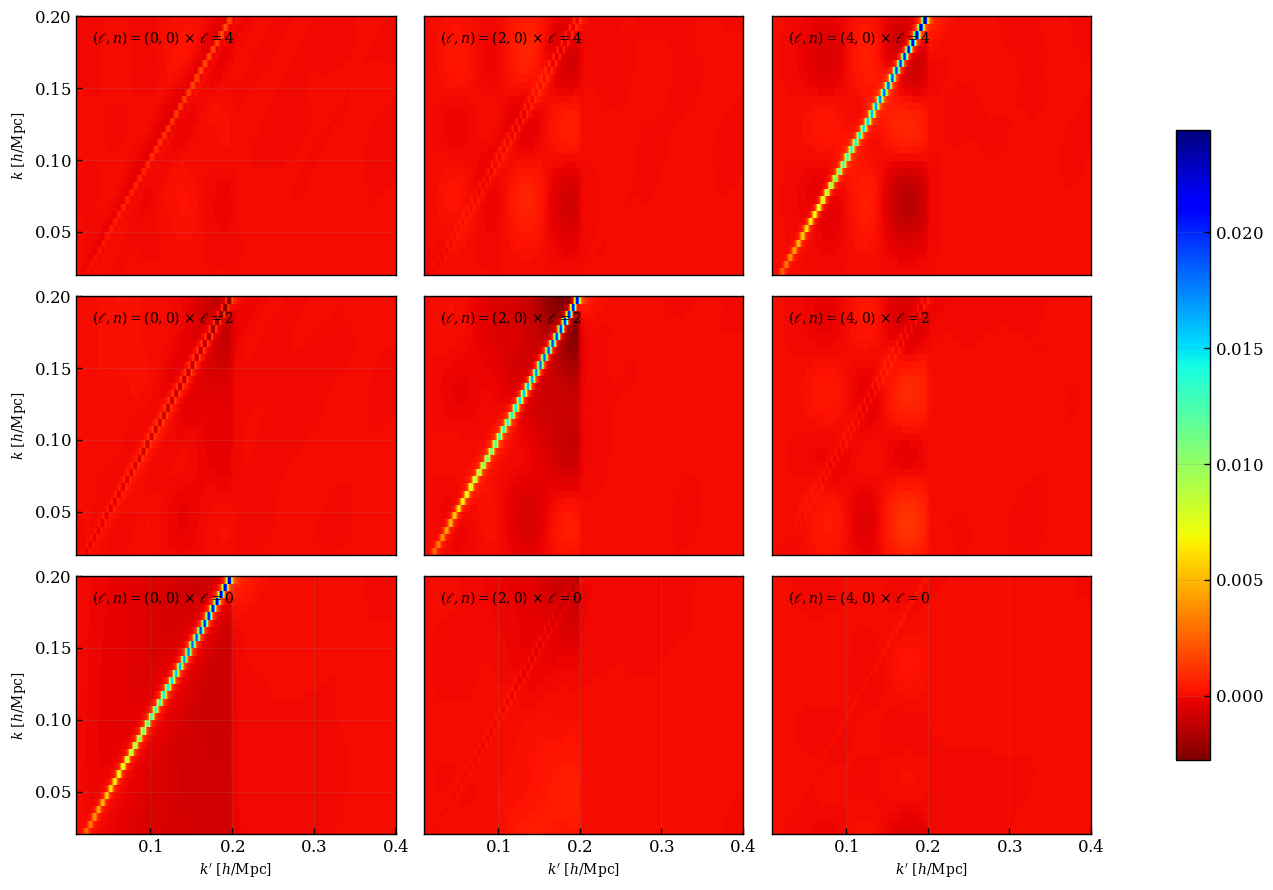

In [458]:
norm = Normalize(vmin=0, vmax=1)

plot_matrix(anew, x1=wmatrixnew.xin, x2=wmatrixnew.xout, xlabel1=r'$k^\prime$ [$h/\mathrm{Mpc}$]', xlabel2=r'$k$ [$h/\mathrm{Mpc}$]',
            barlabel=None, label1=[proj.latex(inline=True) for proj in wmatrixnew.projsin], label2=[proj.latex(inline=True) for proj in wmatrixnew.projsout])
plt.savefig(os.path.join(plots_dir, 'wmatrix_rpcut_marginalized.png'), dpi=300)
plt.show()

In [459]:
wm = BaseMatrix.load('/global/cfs/cdirs/desi/users/mpinon/windows/wm_mock0_ELG_complete_SGC.npy')
wm_rpcut = BaseMatrix.load('/global/cfs/cdirs/desi/users/mpinon/windows/wm_mock0_ELG_complete_SGC_rp2.5.npy')

#wm.select_proj(projsin=[0], projsout=[(0, None)])
#wm_rpcut.select_proj(projsin=[0], projsout=[(0, None)])

for iout, projout in enumerate(wm.projsout):
    wm.slice_x(sliceout=slice(0, len(wm.xout[iout]) // factorout * factorout, factorout), projsout=projout)
    wm_rpcut.slice_x(sliceout=slice(0, len(wm_rpcut.xout[iout]) // factorout * factorout, factorout), projsout=projout)

wm.select_x(xoutlim=klim[0][:2])
wm_rpcut.select_x(xoutlim=klim[0][:2])

wm.select_x(xinlim=(0.01, 0.4))
wm_rpcut.select_x(xinlim=(0.01, 0.4))

a = wm.unpacked()
a_rpcut = wm_rpcut.unpacked()

In [460]:
diff = [[ba_rpcut - ba for ba, ba_rpcut in zip(ca, ca_rpcut)] for ca, ca_rpcut in zip(a, a_rpcut)]

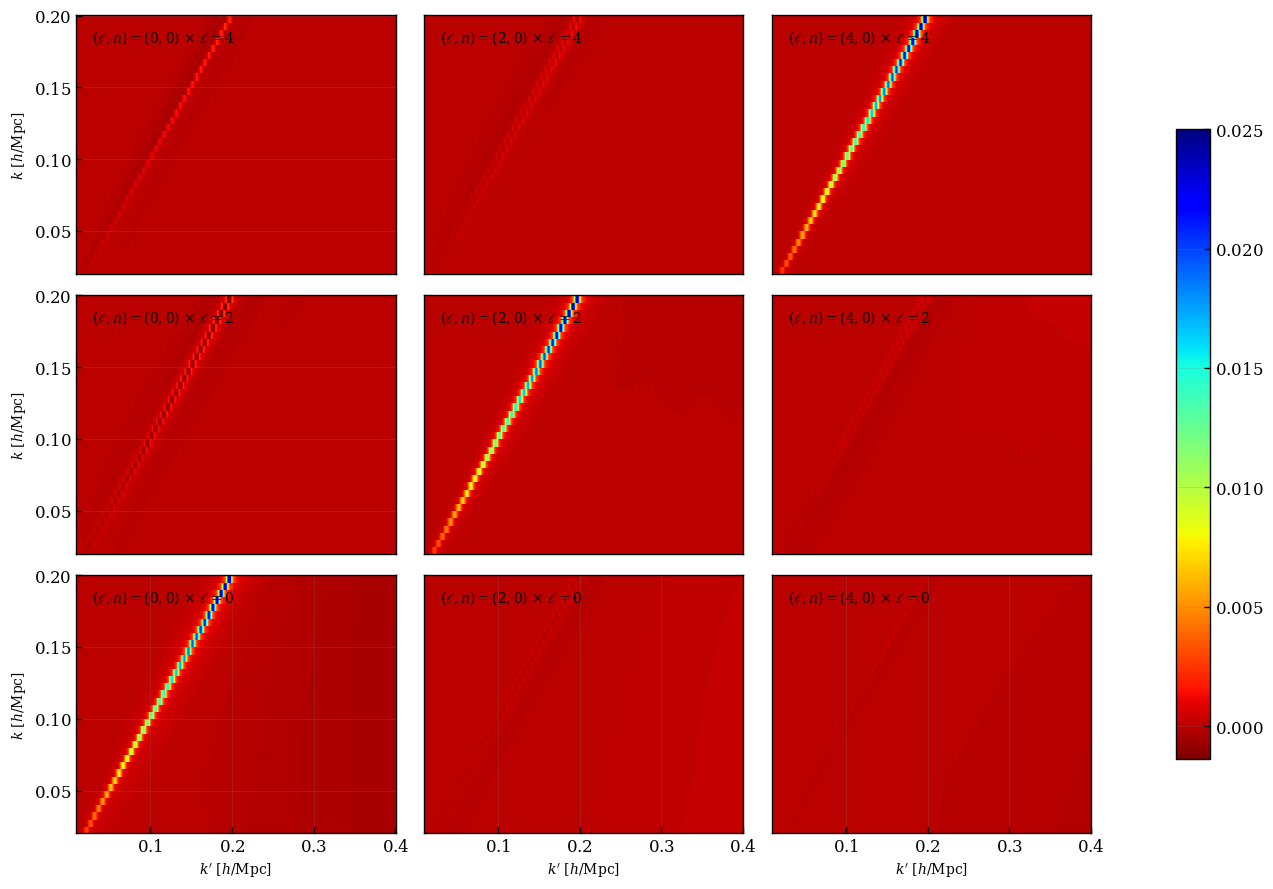

In [461]:
from matplotlib.colors import Normalize

plot_matrix(a_rpcut, x1=wm.xin, x2=wm.xout, xlabel1=r'$k^\prime$ [$h/\mathrm{Mpc}$]', xlabel2=r'$k$ [$h/\mathrm{Mpc}$]',
            barlabel=None, label1=[proj.latex(inline=True) for proj in wm.projsin], label2=[proj.latex(inline=True) for proj in wm.projsout])
plt.show()

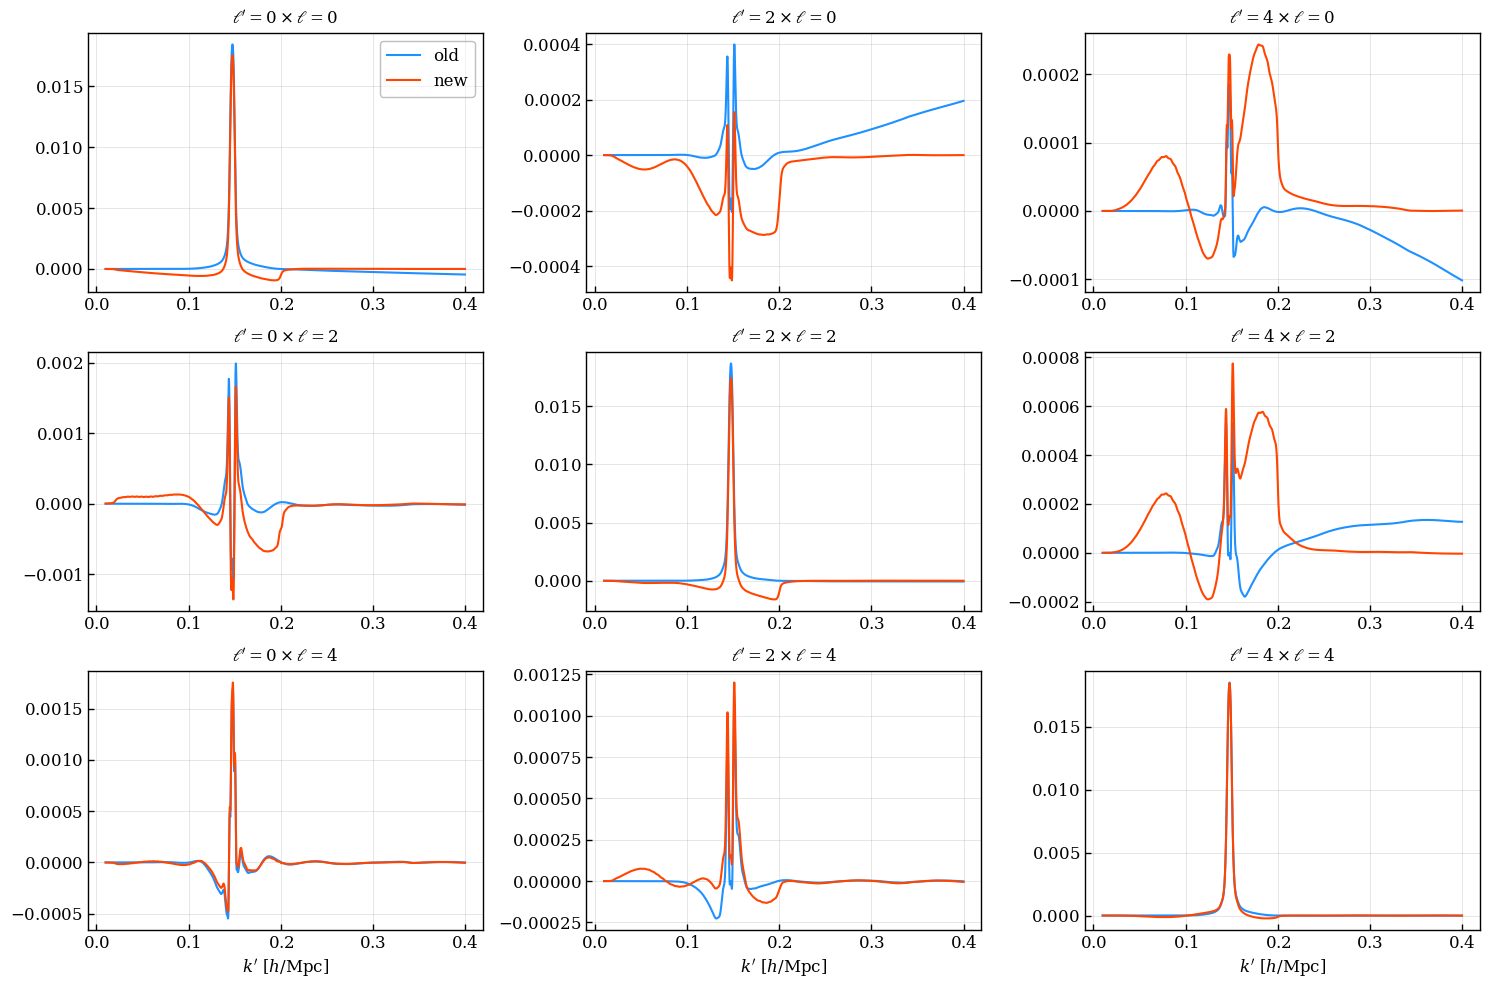

In [464]:
kval = 0.15
indexout = np.abs(wm.xout[0] - kval).argmin()

fig, lax = plt.subplots(len(wm.projsout), len(wm.projsin), figsize=(15, 10))
for iin, projin in enumerate(wm.projsin):
    for iout, projout in enumerate(wm.projsout):
        if np.asarray(lax).ndim > 0:
            ax = lax[iout][iin]
        else:
            ax = lax
        # Indices in approximative window matrix
        norm = 1.
        ax.plot(wm.xin[iin], a_rpcut[iin][iout][:, indexout] / norm, label='old', color='dodgerblue')
        ax.plot(wm.xin[iin], anew[iin][iout][:, indexout] / norm, color='orangered', label='new')
        ax.set_title(r'$\ell^\prime = {:d} \times \ell = {:d}$'.format(projin.ell, projout.ell))
        ax.grid(True)
        if iout == len(wm.projsout) - 1: ax.set_xlabel(r'$k^{\prime}$ [$h/\mathrm{Mpc}$]')
        if iin == iout == 0: ax.legend()
plt.savefig(os.path.join(plots_dir, 'wmatrix_rpcut_marginalized_fixedk.png'), dpi=300)
plt.show()